In [99]:
import pandas as pd
from obp.dataset import OpenBanditDataset
import os
import plotly.express as px
import numpy as np
import string
import plotly.graph_objects as go
import math
from plotly.subplots import make_subplots

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

# Import visualization functions from our custom module
import importlib
import visualizations
importlib.reload(visualizations)
from visualizations import plot_bar_chart, plot_distribution_with_cdf, plot_histogram_with_stats, plot_boxplot_with_stats

print(os.getcwd())

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/Users/armandoordoricadelatorre/Documents/U of T/PhD/PhD Research/OBP_Replication


### Helper functions

In [82]:
def remap_user_features(df, feature_cols):
    """
    Map hash values in user_feature_N to short readable codes like A1, B1, ...
    """
    df_copy = df.copy()
    mapping_dicts = {}

    for col in feature_cols:
        # Extract the feature index (N from 'user_feature_N')
        feature_idx = col.split("_")[-1]
        uniques = df[col].dropna().unique()

        # Build codes A{N}, B{N}, C{N}...
        codes = [f"{letter}{feature_idx}" for letter in string.ascii_uppercase[:len(uniques)]]
        mapping = dict(zip(uniques, codes))

        df_copy[col] = df[col].map(mapping)
        mapping_dicts[col] = mapping

    return df_copy, mapping_dicts


def calculate_propensity_stats(df, groupby_col='item_id'):
    """
    Calculate manual propensity statistics for a given groupby column.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The dataframe containing the logged data
    groupby_col : str or list
        Column(s) to group by (default: 'item_id')
    
    Returns:
    --------
    propensity_df : pd.DataFrame
        DataFrame with counts, total, and manual propensity
    stats_dict : dict
        Dictionary with summary statistics (mean, p25, p50, p75, p99)
    stats_df : pd.DataFrame
        DataFrame formatted for plotting statistics
    """
    # Calculate counts and propensities
    propensity_df = df.groupby(groupby_col).size().to_frame()
    propensity_df.columns = ['count_of_occurrences']
    propensity_df['total'] = propensity_df['count_of_occurrences'].sum()
    propensity_df['manual_propensity'] = propensity_df['count_of_occurrences'] / propensity_df['total']
    
    # Calculate summary statistics
    stats_dict = {
        'mean': propensity_df['manual_propensity'].mean(),
        'p25': propensity_df['manual_propensity'].quantile(0.25),
        'p50': propensity_df['manual_propensity'].quantile(0.50),  # median
        'p75': propensity_df['manual_propensity'].quantile(0.75),
        'p99': propensity_df['manual_propensity'].quantile(0.99),
    }
    
    # Create DataFrame for plotting
    stats_df = pd.DataFrame([stats_dict]).T.reset_index()
    stats_df.columns = ['statistic', 'value']
    
    # Print summary
    print("Manual Propensity Statistics:")
    for stat, value in stats_dict.items():
        print(f"  {stat}: {value:.6f}")
    
    return propensity_df, stats_dict, stats_df

#### Reusable Functions for Distribution Analysis

The following functions provide a modular approach to analyzing and visualizing distributions:

**`calculate_distribution_stats(df, value_col, groupby_col, groupby_col_as_string=True)`** *(defined in notebook)*
- **Purpose**: Process data and calculate statistics for a value column grouped by another column
- **Returns**: 
  - `plot_df`: DataFrame with string version of groupby column for plotting
  - `stats_df`: Statistics (mean, p25, p50, p75, p99) per group
  - `summary_df`: Detailed summary statistics per group

**`plot_boxplot_with_stats(plot_df, stats_df, value_col, groupby_col_str, ...)`** *(imported from visualizations.py)*
- **Purpose**: Create a boxplot with optional mean overlay and statistics in hover
- **Features**:
  - Boxplot showing distribution per group
  - Red dots showing mean values (optional)
  - Hover shows all quartile statistics (p25, p50, p75, p99)
  - Customizable title, labels, and height
- **Location**: This function is now part of the `visualizations` module for reusability across notebooks

**Example Usage**:
```python
# 1. Process the data (using notebook function)
plot_df, stats_df, summary_df = calculate_distribution_stats(
    df=log_df_readable,
    value_col='propensity_score',
    groupby_col='item_id'
)

# 2. Create visualization (using imported function)
fig = plot_boxplot_with_stats(
    plot_df=plot_df,
    stats_df=stats_df,
    value_col='propensity_score',
    groupby_col_str='item_id_str',
    title='My Custom Title',
    height=600
)
fig.show()
```

**Separation of Concerns**:
- **Data Processing** (`calculate_distribution_stats`): Kept in notebook for flexibility in data manipulation
- **Visualization** (`plot_boxplot_with_stats`): Moved to `visualizations.py` for reusability across projects

In [83]:
def calculate_distribution_stats(df, value_col, groupby_col, groupby_col_as_string=True):
    """
    Calculate statistics for a value column grouped by another column.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The dataframe containing the data
    value_col : str
        Column name containing the values to analyze (e.g., 'propensity_score')
    groupby_col : str
        Column name to group by (e.g., 'item_id', 'position')
    groupby_col_as_string : bool
        Whether to convert the groupby column to string for categorical display
    
    Returns:
    --------
    stats_df : pd.DataFrame
        DataFrame with statistics per group (mean, p25, p50, p75, p99)
    summary_df : pd.DataFrame
        Detailed summary statistics per group (count, mean, std, min, quartiles, max)
    """
    # Create a working copy
    plot_df = df.copy()
    
    # Convert groupby column to string if needed for categorical display
    if groupby_col_as_string:
        groupby_col_str = f'{groupby_col}_str'
        plot_df[groupby_col_str] = plot_df[groupby_col].astype(str)
    else:
        groupby_col_str = groupby_col
    
    # Calculate statistics per group for visualization
    stats_df = plot_df.groupby(groupby_col_str)[value_col].agg([
        ('mean', 'mean'),
        ('p25', lambda x: x.quantile(0.25)),
        ('p50', lambda x: x.quantile(0.50)),
        ('p75', lambda x: x.quantile(0.75)),
        ('p99', lambda x: x.quantile(0.99))
    ]).reset_index()
    
    # Calculate detailed summary statistics (using original groupby column)
    summary_df = df.groupby(groupby_col)[value_col].agg([
        ('count', 'count'),
        ('mean', 'mean'),
        ('std', 'std'),
        ('min', 'min'),
        ('25%', lambda x: x.quantile(0.25)),
        ('50%', lambda x: x.quantile(0.50)),
        ('75%', lambda x: x.quantile(0.75)),
        ('max', 'max')
    ]).round(4)
    
    return plot_df, stats_df, summary_df


### Import logged data from `all.csv` and `item_context.csv`

In [84]:

# BTS / ALL sample
log_df   = pd.read_csv("zr-obp/obd/bts/all/all.csv", index_col=0)
items_df = pd.read_csv("zr-obp/obd/bts/all/item_context.csv", index_col=0)

print("log_df shape:", log_df.shape)
print("items_df shape:", items_df.shape)

print("\nlog_df columns:")
print(log_df.columns.tolist()[:40])  # peek first ~40 col names

print("\nfirst 5 log rows:")
print(log_df.head())

print("\nfirst 5 item rows:")
print(items_df.head())

log_df shape: (10000, 89)
items_df shape: (80, 5)

log_df columns:
['timestamp', 'item_id', 'position', 'click', 'propensity_score', 'user_feature_0', 'user_feature_1', 'user_feature_2', 'user_feature_3', 'user-item_affinity_0', 'user-item_affinity_1', 'user-item_affinity_2', 'user-item_affinity_3', 'user-item_affinity_4', 'user-item_affinity_5', 'user-item_affinity_6', 'user-item_affinity_7', 'user-item_affinity_8', 'user-item_affinity_9', 'user-item_affinity_10', 'user-item_affinity_11', 'user-item_affinity_12', 'user-item_affinity_13', 'user-item_affinity_14', 'user-item_affinity_15', 'user-item_affinity_16', 'user-item_affinity_17', 'user-item_affinity_18', 'user-item_affinity_19', 'user-item_affinity_20', 'user-item_affinity_21', 'user-item_affinity_22', 'user-item_affinity_23', 'user-item_affinity_24', 'user-item_affinity_25', 'user-item_affinity_26', 'user-item_affinity_27', 'user-item_affinity_28', 'user-item_affinity_29', 'user-item_affinity_30']

first 5 log rows:
           

### Remapping categorical features to readable categories

In [85]:
user_feature_cols = [c for c in log_df.columns if c.startswith("user_feature")]
log_df_readable, mappings = remap_user_features(log_df, user_feature_cols)

print("Sample remapped features:")
display(log_df_readable[user_feature_cols].head())

print("\nMappings used:")
for feat, mapping in mappings.items():
    print(f"{feat}: {mapping}")

Sample remapped features:


,user_feature_0,user_feature_1,user_feature_2,user_feature_3
0,A0,A1,A2,A3
1,A0,B1,B2,B3
2,A0,A1,C2,A3
3,A0,A1,A2,B3
4,A0,A1,C2,B3



Mappings used:
user_feature_0: {'81ce123cbb5bd8ce818f60fb3586bba5': 'A0', 'cef3390ed299c09874189c387777674a': 'B0', '4ae385d792f81dde128124a925a830de': 'C0'}
user_feature_1: {'03a5648a76832f83c859d46bc06cb64a': 'A1', '2d03db5543b14483e52d761760686b64': 'B1', '6ff54aa8ff7a9dde75161c20a3ee4231': 'C1', 'f1c2d6a32ec39249160cf784b63f4c6f': 'D1', '8b50621825ffd909dd8d8317d366271f': 'E1'}
user_feature_2: {'7bc94a2da491829b777c49c4b5e480f2': 'A2', '2723d2eb8bba04e0362098011fa3997b': 'B2', 'c2e4f76cdbabecd33b8c762aeef386b3': 'C2', '719dab53a7560218a9d1f96b25d6fa32': 'D2', '9b2d331c329ceb74d3dcfb48d8798c78': 'E2', '302deff13f835d731df1c842eed95971': 'F2', '9f4e8271d3d3014af5f35124c2de5082': 'G2', '7ae37150e596e6e8f19e27a06bd4d359': 'H2', 'c7cce49040b6630e9b5484dfcc0e6cd1': 'I2'}
user_feature_3: {'c39b0c7dd5d4eb9a18e7db6ba2f258f8': 'A3', '9bde591ffaab8d54c457448e4dca6f53': 'B3', '05b76f5e97e51128862059ac7df9e42a': 'C3', 'f97571b9c14a786aab269f0b427d2a85': 'D3', '06128286bcc64b6a4b0fb7bc0328fe17'

In [86]:
log_df_readable.head()

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,user-item_affinity_1,user-item_affinity_2,user-item_affinity_3,user-item_affinity_4,user-item_affinity_5,user-item_affinity_6,user-item_affinity_7,user-item_affinity_8,user-item_affinity_9,user-item_affinity_10,user-item_affinity_11,user-item_affinity_12,user-item_affinity_13,user-item_affinity_14,user-item_affinity_15,user-item_affinity_16,user-item_affinity_17,user-item_affinity_18,user-item_affinity_19,user-item_affinity_20,user-item_affinity_21,user-item_affinity_22,user-item_affinity_23,user-item_affinity_24,user-item_affinity_25,user-item_affinity_26,user-item_affinity_27,user-item_affinity_28,user-item_affinity_29,user-item_affinity_30,user-item_affinity_31,user-item_affinity_32,user-item_affinity_33,user-item_affinity_34,user-item_affinity_35,user-item_affinity_36,user-item_affinity_37,user-item_affinity_38,user-item_affinity_39,user-item_affinity_40,user-item_affinity_41,user-item_affinity_42,user-item_affinity_43,user-item_affinity_44,user-item_affinity_45,user-item_affinity_46,user-item_affinity_47,user-item_affinity_48,user-item_affinity_49,user-item_affinity_50,user-item_affinity_51,user-item_affinity_52,user-item_affinity_53,user-item_affinity_54,user-item_affinity_55,user-item_affinity_56,user-item_affinity_57,user-item_affinity_58,user-item_affinity_59,user-item_affinity_60,user-item_affinity_61,user-item_affinity_62,user-item_affinity_63,user-item_affinity_64,user-item_affinity_65,user-item_affinity_66,user-item_affinity_67,user-item_affinity_68,user-item_affinity_69,user-item_affinity_70,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79
0,2019-11-24 00:00:17.004101+00:00,79,2,0,0.087125,A0,A1,A2,A3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-11-24 00:00:19.715857+00:00,14,1,0,0.006235,A0,B1,B2,B3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-11-24 00:01:04.303227+00:00,18,2,0,0.061300,A0,A1,C2,A3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-11-24 00:01:11.571162+00:00,28,1,0,0.019430,A0,A1,A2,B3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-11-24 00:02:41.811768+00:00,65,2,0,0.019375,A0,A1,C2,B3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## EDA 

### Histogram on number of rows per day 

In [87]:
# Ensure proper datetime dtype (keeps timezone info)
log_df = log_df_readable.copy()
log_df['timestamp'] = pd.to_datetime(log_df['timestamp'], utc=True, errors='coerce')
log_df = log_df.loc[log_df['timestamp'].notna()]

# convert to your local timezone (example: Toronto)
log_df['timestamp'] = log_df['timestamp'].dt.tz_convert('America/Toronto')

# # Count rows per day, including days with zero rows
daily_counts = (
    log_df
    .set_index('timestamp')
    .resample('D')
    .size()
    .rename('rows')
    .reset_index()
)

# Use the plotting function
fig = plot_bar_chart(
    data=daily_counts,
    x_col='timestamp',
    y_col='rows',
    x_title='Date',
    y_title='Rows',
    title='Number of Rows per Day',
    height=500,
    show_values=True,
    value_format='{:,}'  # thousands separator
)

fig.show()


### Counting user features vs user-item features

In [88]:
user_feature_cols = [c for c in log_df_readable.columns if c.startswith('user_feature_')]
affinity_cols = [c for c in log_df_readable.columns if c.startswith('user-item_affinity_')]

user_feature_cols, len(affinity_cols)

(['user_feature_0', 'user_feature_1', 'user_feature_2', 'user_feature_3'], 80)

### Cardinality per feature

In [89]:
feat_summary = []
for c in user_feature_cols:
    s = log_df_readable[c]
    vc = s.value_counts(dropna=False)
    feat_summary.append({
        'feature': c,
        'n_unique': s.nunique(dropna=True),
        'n_missing': int(s.isna().sum()),
        'top_value': None if vc.empty else vc.index[0],
        'top_count': 0 if vc.empty else int(vc.iloc[0]),
        'top_share': 0.0 if vc.empty else float(vc.iloc[0] / len(s)),
    })
pd.DataFrame(feat_summary).sort_values('n_unique', ascending=False)

,feature,n_unique,n_missing,top_value,top_count,top_share
2,user_feature_2,9,0,B2,2439,0.2439
3,user_feature_3,9,0,B3,3667,0.3667
1,user_feature_1,5,0,A1,8322,0.8322
0,user_feature_0,3,0,A0,8123,0.8123


In [90]:
len(log_df_readable)

10000

In [91]:
# Calculate manual propensity statistics using the helper function
propensity_manual_df, propensity_stats, stats_df = calculate_propensity_stats(
    log_df_readable, 
    groupby_col='item_id'
)

# Display the statistics DataFrame
display(stats_df)

# Plot the statistics using the reusable plot_bar_chart function
fig = plot_bar_chart(
    data=stats_df,
    x_col='statistic',
    y_col='value',
    x_title='Statistic',
    y_title='Propensity Value',
    title='Manual Propensity Statistics (Mean and Percentiles)',
    height=500,
    show_values=True,
    value_format='{:.6f}'
)

# Customize x-axis ordering
fig.update_layout(
    xaxis={'categoryorder': 'array', 'categoryarray': ['mean', 'p25', 'p50', 'p75', 'p99']},
    yaxis_title='Propensity Score'
)

fig.show()

Manual Propensity Statistics:
  mean: 0.012500
  p25: 0.001700
  p50: 0.003850
  p75: 0.012175
  p99: 0.082929


,statistic,value
0,mean,0.012500
1,p25,0.001700
2,p50,0.003850
3,p75,0.012175
4,p99,0.082929


### Distribution of manual propensity scores with statistics

In [92]:
# Create a histogram with vertical lines for each statistic using the reusable function
fig = plot_histogram_with_stats(
    data=propensity_manual_df,
    column_name='manual_propensity',
    stats_dict=propensity_stats,
    title='Distribution of Manual Propensity Scores with Statistics',
    xlabel='Manual Propensity Score',
    height=500,
    nbins=50
)

fig.show()

### Propensity Score Distribution - Rounded to 2 Decimals

To make the PDF/CDF readable and interpretable, we'll round propensity scores to 2 decimal places.
This allows us to see what propensity score value corresponds to a given cumulative percentage.

In [93]:
# Create a working dataframe with rounded propensity scores
propensity_rounded_df = log_df_readable.copy()

# Round propensity scores to 2 decimal places
propensity_rounded_df['propensity_score_rounded'] = propensity_rounded_df['propensity_score'].round(2)

# Show summary statistics
print("Propensity Score Summary (Rounded to 2 Decimals):")
print("="*60)
print(f"Original unique values: {log_df_readable['propensity_score'].nunique():,}")
print(f"Rounded unique values:  {propensity_rounded_df['propensity_score_rounded'].nunique():,}")
print(f"Total observations:     {len(propensity_rounded_df):,}")
print("="*60)

# Show some key statistics
print("\nKey Percentiles (Rounded Propensity Scores):")
for p in [10, 25, 50, 75, 90, 95, 99]:
    val = propensity_rounded_df['propensity_score_rounded'].quantile(p/100)
    print(f"  {p:2d}th percentile: {val:.2f} ({p}% of rows have propensity score ≤ {val:.2f})")

print("="*60)

# Plot the PDF and CDF of rounded propensity scores using our reusable function
plot_distribution_with_cdf(
    data=propensity_rounded_df,
    column_name='propensity_score_rounded',
    title='Propensity Score (from original dataset) Distribution (Rounded to 2 Decimals) - All Rows',
    sort_by='value',  # Sort by propensity score value
    height=600
)

Propensity Score Summary (Rounded to 2 Decimals):
Original unique values: 7,883
Rounded unique values:  90
Total observations:     10,000

Key Percentiles (Rounded Propensity Scores):
  10th percentile: 0.01 (10% of rows have propensity score ≤ 0.01)
  25th percentile: 0.02 (25% of rows have propensity score ≤ 0.02)
  50th percentile: 0.06 (50% of rows have propensity score ≤ 0.06)
  75th percentile: 0.15 (75% of rows have propensity score ≤ 0.15)
  90th percentile: 0.24 (90% of rows have propensity score ≤ 0.24)
  95th percentile: 0.34 (95% of rows have propensity score ≤ 0.34)
  99th percentile: 0.71 (99% of rows have propensity score ≤ 0.71)

Distribution Summary: propensity_score_rounded
Total observations: 10,000
Unique values: 90

Top 5 values:
 propensity_score_rounded  count  percentage  cumulative_pct
                     0.00    750        7.50            7.50
                     0.01   1087       10.87           18.37
                     0.02    844        8.44           2

In [94]:
log_df_readable['propensity_score'].max()

0.95424

In [95]:
log_df_readable[log_df_readable['propensity_score']== log_df_readable['propensity_score'].max()]

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,user-item_affinity_1,user-item_affinity_2,user-item_affinity_3,user-item_affinity_4,user-item_affinity_5,user-item_affinity_6,user-item_affinity_7,user-item_affinity_8,user-item_affinity_9,user-item_affinity_10,user-item_affinity_11,user-item_affinity_12,user-item_affinity_13,user-item_affinity_14,user-item_affinity_15,user-item_affinity_16,user-item_affinity_17,user-item_affinity_18,user-item_affinity_19,user-item_affinity_20,user-item_affinity_21,user-item_affinity_22,user-item_affinity_23,user-item_affinity_24,user-item_affinity_25,user-item_affinity_26,user-item_affinity_27,user-item_affinity_28,user-item_affinity_29,user-item_affinity_30,user-item_affinity_31,user-item_affinity_32,user-item_affinity_33,user-item_affinity_34,user-item_affinity_35,user-item_affinity_36,user-item_affinity_37,user-item_affinity_38,user-item_affinity_39,user-item_affinity_40,user-item_affinity_41,user-item_affinity_42,user-item_affinity_43,user-item_affinity_44,user-item_affinity_45,user-item_affinity_46,user-item_affinity_47,user-item_affinity_48,user-item_affinity_49,user-item_affinity_50,user-item_affinity_51,user-item_affinity_52,user-item_affinity_53,user-item_affinity_54,user-item_affinity_55,user-item_affinity_56,user-item_affinity_57,user-item_affinity_58,user-item_affinity_59,user-item_affinity_60,user-item_affinity_61,user-item_affinity_62,user-item_affinity_63,user-item_affinity_64,user-item_affinity_65,user-item_affinity_66,user-item_affinity_67,user-item_affinity_68,user-item_affinity_69,user-item_affinity_70,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79
871,2019-11-24 12:11:57.430499+00:00,49,1,0,0.95424,A0,D1,B2,B3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
879,2019-11-24 12:14:03.832273+00:00,49,1,0,0.95424,A0,A1,C2,A3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
880,2019-11-24 12:14:50.257724+00:00,49,1,0,0.95424,A0,A1,B2,B3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
884,2019-11-24 12:16:03.655893+00:00,49,1,0,0.95424,A0,B1,A2,D3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
886,2019-11-24 12:16:53.154005+00:00,49,1,0,0.95424,A0,A1,B2,B3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
893,2019-11-24 12:20:23.535788+00:00,49,1,0,0.95424,A0,A1,D2,B3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [96]:
log_df_readable.head()

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,user-item_affinity_1,user-item_affinity_2,user-item_affinity_3,user-item_affinity_4,user-item_affinity_5,user-item_affinity_6,user-item_affinity_7,user-item_affinity_8,user-item_affinity_9,user-item_affinity_10,user-item_affinity_11,user-item_affinity_12,user-item_affinity_13,user-item_affinity_14,user-item_affinity_15,user-item_affinity_16,user-item_affinity_17,user-item_affinity_18,user-item_affinity_19,user-item_affinity_20,user-item_affinity_21,user-item_affinity_22,user-item_affinity_23,user-item_affinity_24,user-item_affinity_25,user-item_affinity_26,user-item_affinity_27,user-item_affinity_28,user-item_affinity_29,user-item_affinity_30,user-item_affinity_31,user-item_affinity_32,user-item_affinity_33,user-item_affinity_34,user-item_affinity_35,user-item_affinity_36,user-item_affinity_37,user-item_affinity_38,user-item_affinity_39,user-item_affinity_40,user-item_affinity_41,user-item_affinity_42,user-item_affinity_43,user-item_affinity_44,user-item_affinity_45,user-item_affinity_46,user-item_affinity_47,user-item_affinity_48,user-item_affinity_49,user-item_affinity_50,user-item_affinity_51,user-item_affinity_52,user-item_affinity_53,user-item_affinity_54,user-item_affinity_55,user-item_affinity_56,user-item_affinity_57,user-item_affinity_58,user-item_affinity_59,user-item_affinity_60,user-item_affinity_61,user-item_affinity_62,user-item_affinity_63,user-item_affinity_64,user-item_affinity_65,user-item_affinity_66,user-item_affinity_67,user-item_affinity_68,user-item_affinity_69,user-item_affinity_70,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79
0,2019-11-24 00:00:17.004101+00:00,79,2,0,0.087125,A0,A1,A2,A3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-11-24 00:00:19.715857+00:00,14,1,0,0.006235,A0,B1,B2,B3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-11-24 00:01:04.303227+00:00,18,2,0,0.061300,A0,A1,C2,A3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-11-24 00:01:11.571162+00:00,28,1,0,0.019430,A0,A1,A2,B3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-11-24 00:02:41.811768+00:00,65,2,0,0.019375,A0,A1,C2,B3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Propensity Score Distribution by Item ID

Visualize how propensity scores are distributed across different items using boxplots.

In [100]:
# Process data and calculate statistics
plot_df, stats_by_item, summary_by_item = calculate_distribution_stats(
    df=log_df_readable,
    value_col='propensity_score',
    groupby_col='item_id',
    groupby_col_as_string=True
)

# Create the boxplot visualization
fig = plot_boxplot_with_stats(
    plot_df=plot_df,
    stats_df=stats_by_item,
    value_col='propensity_score',
    groupby_col_str='item_id_str',
    title='Distribution of Propensity Scores by Item ID',
    xlabel='Item ID',
    ylabel='Propensity Score',
    height=600,
    show_mean_overlay=True
)

fig.show()

# Print summary statistics
print("\nPropensity Score Statistics by Item ID:")
print("="*60)

print("\nFirst 10 items:")
display(summary_by_item.head(10))

print("\nItems with highest mean propensity:")
display(summary_by_item.nlargest(5, 'mean'))

print("\nItems with lowest mean propensity:")
display(summary_by_item.nsmallest(5, 'mean'))


Propensity Score Statistics by Item ID:

First 10 items:


,count,mean,std,min,25%,50%,75%,max
item_id,,,,,,,,
0,125,0.0509,0.0531,0.0024,0.0176,0.0364,0.0632,0.2786
1,31,0.0077,0.0073,0.0006,0.0026,0.0059,0.0102,0.0349
2,17,0.0049,0.0053,0.0001,0.0012,0.0030,0.0066,0.0189
3,46,0.0175,0.0200,0.0002,0.0044,0.0115,0.0217,0.1062
4,17,0.0133,0.0204,0.0006,0.0018,0.0049,0.0133,0.0690
5,22,0.0062,0.0047,0.0008,0.0027,0.0053,0.0093,0.0172
6,14,0.0064,0.0068,0.0001,0.0013,0.0044,0.0082,0.0205
7,741,0.1593,0.1568,0.0038,0.0767,0.1219,0.1700,0.8672
8,48,0.0122,0.0118,0.0004,0.0034,0.0065,0.0174,0.0430



Items with highest mean propensity:


,count,mean,std,min,25%,50%,75%,max
item_id,,,,,,,,
49,408,0.2924,0.3096,0.0021,0.0420,0.1394,0.5897,0.9542
39,756,0.2248,0.1828,0.0016,0.0894,0.1821,0.2767,0.7691
51,1105,0.1875,0.0961,0.0043,0.1243,0.1843,0.2408,0.6199
7,741,0.1593,0.1568,0.0038,0.0767,0.1219,0.1700,0.8672
61,704,0.1358,0.0945,0.0041,0.0735,0.1207,0.1789,0.6469



Items with lowest mean propensity:


,count,mean,std,min,25%,50%,75%,max
item_id,,,,,,,,
56,9,0.0019,0.0014,0.0001,0.0009,0.0016,0.0029,0.0047
20,11,0.0034,0.0043,0.0004,0.0012,0.0014,0.0031,0.0120
9,18,0.0036,0.0033,0.0003,0.0010,0.0023,0.0065,0.0099
74,13,0.0037,0.0037,0.0005,0.0015,0.0017,0.0038,0.0127
10,9,0.0041,0.0023,0.0010,0.0027,0.0032,0.0069,0.0072


### Propensity Score Distribution by Position

Visualize how propensity scores are distributed across different positions (1, 2, 3) using the same reusable functions.

In [103]:
# Process data and calculate statistics for position
plot_df_pos, stats_by_position, summary_by_position = calculate_distribution_stats(
    df=log_df_readable,
    value_col='propensity_score',
    groupby_col='position',
    groupby_col_as_string=True
)

# Create the boxplot visualization
fig = plot_boxplot_with_stats(
    plot_df=plot_df_pos,
    stats_df=stats_by_position,
    value_col='propensity_score',
    groupby_col_str='position_str',
    title='Distribution of Propensity Scores by Position',
    xlabel='Position',
    ylabel='Propensity Score',
    height=500,
    show_mean_overlay=True
)

fig.show()

# Print summary statistics
print("\nPropensity Score Statistics by Position:")
print("="*60)
display(summary_by_position)

print("\nKey Insights:")
print(f"  • Position with highest mean propensity: {summary_by_position['mean'].idxmax()}")
print(f"    Mean: {summary_by_position['mean'].max():.4f}")
print(f"  • Position with lowest mean propensity: {summary_by_position['mean'].idxmin()}")
print(f"    Mean: {summary_by_position['mean'].min():.4f}")


Propensity Score Statistics by Position:


,count,mean,std,min,25%,50%,75%,max
position,,,,,,,,
1,3362,0.1467,0.1977,0.0000,0.0189,0.0599,0.1821,0.9542
2,3317,0.0956,0.0850,0.0001,0.0251,0.0680,0.1514,0.4563
3,3321,0.0838,0.0692,0.0001,0.0248,0.0649,0.1313,0.3211



Key Insights:
  • Position with highest mean propensity: 1
    Mean: 0.1467
  • Position with lowest mean propensity: 3
    Mean: 0.0838


### Propensity Score Distribution by User Features

Loop through all user features to analyze propensity score distributions across each feature's values.

In [109]:
# Loop through all user features and create visualizations
for i in range(4):  # user_feature_0 through user_feature_3
    feature_name = f'user_feature_{i}'
    
    print(f"\n{'='*70}")
    print(f"Processing: {feature_name}")
    print(f"{'='*70}\n")
    
    # Process data and calculate statistics
    plot_df, stats_by_feature, summary_by_feature = calculate_distribution_stats(
        df=log_df_readable,
        value_col='propensity_score',
        groupby_col=feature_name,
        groupby_col_as_string=False  # Already a string/categorical
    )
    
    # Create the boxplot visualization
    fig = plot_boxplot_with_stats(
        plot_df=plot_df,
        stats_df=stats_by_feature,
        value_col='propensity_score',
        groupby_col_str=feature_name,
        title=f'Distribution of Propensity Scores by User Feature {i}',
        xlabel=f'User Feature {i}',
        ylabel='Propensity Score',
        height=500,
        show_mean_overlay=True
    )
    
    fig.show()
    
    # Print summary statistics
    print(f"\nPropensity Score Statistics by User Feature {i}:")
    print("="*60)
    display(summary_by_feature)
    print("\n")


Processing: user_feature_0




Propensity Score Statistics by User Feature 0:


,count,mean,std,min,25%,50%,75%,max
user_feature_0,,,,,,,,
A0,8123,0.1086,0.1324,0.0001,0.0223,0.0646,0.1486,0.9542
B0,1808,0.1102,0.1393,0.0000,0.0233,0.0638,0.1505,0.9177
C0,69,0.1070,0.1388,0.0018,0.0220,0.0604,0.1368,0.8863





Processing: user_feature_1




Propensity Score Statistics by User Feature 1:


,count,mean,std,min,25%,50%,75%,max
user_feature_1,,,,,,,,
A1,8322,0.1095,0.1344,0.0000,0.0224,0.0648,0.1506,0.9542
B1,854,0.1099,0.1395,0.0003,0.0220,0.0644,0.1428,0.9542
C1,138,0.0890,0.1099,0.0001,0.0143,0.0588,0.1305,0.8863
D1,681,0.1039,0.1214,0.0001,0.0249,0.0638,0.1438,0.9542
E1,5,0.0640,0.0633,0.0069,0.0279,0.0447,0.0717,0.1690





Processing: user_feature_2




Propensity Score Statistics by User Feature 2:


,count,mean,std,min,25%,50%,75%,max
user_feature_2,,,,,,,,
A2,1569,0.1034,0.1234,0.0000,0.0218,0.0617,0.1452,0.9542
B2,2439,0.1110,0.1355,0.0001,0.0227,0.0659,0.1521,0.9542
C2,2411,0.1097,0.1352,0.0001,0.0225,0.0657,0.1509,0.9542
D2,1407,0.1147,0.1425,0.0001,0.0250,0.0662,0.1534,0.9542
E2,1514,0.1044,0.1301,0.0002,0.0208,0.0600,0.1454,0.9177
F2,491,0.1115,0.1355,0.0001,0.0218,0.0665,0.1411,0.8226
G2,162,0.1024,0.1282,0.0004,0.0180,0.0615,0.1367,0.8487
H2,6,0.0921,0.0838,0.0357,0.0383,0.0392,0.1572,0.2040
I2,1,0.0155,NaN,0.0155,0.0155,0.0155,0.0155,0.0155





Processing: user_feature_3




Propensity Score Statistics by User Feature 3:


,count,mean,std,min,25%,50%,75%,max
user_feature_3,,,,,,,,
A3,3523,0.1096,0.1343,0.0001,0.0237,0.0648,0.1455,0.9542
B3,3667,0.1093,0.1360,0.0001,0.0217,0.0642,0.1508,0.9542
C3,549,0.1178,0.1481,0.0001,0.0244,0.0682,0.1521,0.8487
D3,1164,0.1033,0.1208,0.0002,0.0212,0.0620,0.1468,0.9542
E3,913,0.1079,0.1298,0.0000,0.0206,0.0668,0.1537,0.9144
F3,157,0.0968,0.1206,0.0006,0.0210,0.0550,0.1287,0.7691
G3,1,0.2622,NaN,0.2622,0.2622,0.2622,0.2622,0.2622
H3,25,0.1063,0.1653,0.0030,0.0232,0.0518,0.1351,0.8122
I3,1,0.0827,NaN,0.0827,0.0827,0.0827,0.0827,0.0827


### Variance of Propensity Scores Across Variables

Compare the variance of propensity scores when grouped by different variables (item_id, position, user features).

In [112]:
def compute_propensity_variance(df, groupby_col):
    """
    Compute variance metrics for propensity scores grouped by a variable.
    
    Parameters:
    -----------
    df : pd.DataFrame
        The dataframe containing the data
    groupby_col : str
        Column name to group by
    
    Returns:
    --------
    variance_metrics : dict
        Dictionary with variance metrics:
        - within_group_variance: Average variance within each group
        - between_group_variance: Variance of group means
        - total_variance: Overall variance of propensity scores
        - variance_explained_ratio: Proportion of variance explained by grouping
    group_stats : pd.DataFrame
        DataFrame with mean, variance, and count per group
    """
    # Calculate statistics per group
    group_stats = df.groupby(groupby_col)['propensity_score'].agg([
        ('mean', 'mean'),
        ('variance', 'var'),
        ('std', 'std'),
        ('count', 'count')
    ]).reset_index()
    
    # Total variance (overall)
    total_variance = df['propensity_score'].var()
    
    # Within-group variance (weighted average of group variances)
    total_count = df.shape[0]
    within_group_variance = (group_stats['variance'] * group_stats['count']).sum() / total_count
    
    # Between-group variance (variance of group means, weighted by group sizes)
    overall_mean = df['propensity_score'].mean()
    between_group_variance = ((group_stats['mean'] - overall_mean) ** 2 * group_stats['count']).sum() / total_count
    
    # Variance explained ratio (R-squared analog)
    variance_explained_ratio = between_group_variance / total_variance if total_variance > 0 else 0
    
    variance_metrics = {
        'groupby_variable': groupby_col,
        'n_groups': len(group_stats),
        'total_variance': total_variance,
        'within_group_variance': within_group_variance,
        'between_group_variance': between_group_variance,
        'variance_explained_ratio': variance_explained_ratio
    }
    
    return variance_metrics, group_stats


# Compare variance across different groupings
variables_to_compare = ['item_id', 'position', 'user_feature_0', 'user_feature_1', 
                        'user_feature_2', 'user_feature_3']

variance_comparison = []
all_group_stats = {}

print("="*80)
print("PROPENSITY SCORE VARIANCE ANALYSIS")
print("="*80)

for var in variables_to_compare:
    print(f"\n{'='*80}")
    print(f"Variable: {var}")
    print(f"{'='*80}")
    
    metrics, group_stats = compute_propensity_variance(log_df_readable, var)
    variance_comparison.append(metrics)
    all_group_stats[var] = group_stats
    
    print(f"  Number of groups: {metrics['n_groups']}")
    print(f"  Total variance: {metrics['total_variance']:.6f}")
    print(f"  Within-group variance: {metrics['within_group_variance']:.6f}")
    print(f"  Between-group variance: {metrics['between_group_variance']:.6f}")
    print(f"  Variance explained: {metrics['variance_explained_ratio']:.2%}")
    
    # Show groups with highest and lowest variance
    print(f"\n  Top 3 groups by variance:")
    top_var = group_stats.nlargest(3, 'variance')
    for _, row in top_var.iterrows():
        print(f"    {var}={row[var]}: var={row['variance']:.6f}, mean={row['mean']:.6f}, n={int(row['count'])}")
    
    print(f"\n  Top 3 groups by mean propensity:")
    top_mean = group_stats.nlargest(3, 'mean')
    for _, row in top_mean.iterrows():
        print(f"    {var}={row[var]}: mean={row['mean']:.6f}, var={row['variance']:.6f}, n={int(row['count'])}")

# Create summary DataFrame
variance_summary_df = pd.DataFrame(variance_comparison)
variance_summary_df = variance_summary_df.sort_values('variance_explained_ratio', ascending=False)

print(f"\n{'='*80}")
print("SUMMARY: Variance Comparison Across All Variables")
print(f"{'='*80}\n")
display(variance_summary_df)

print("\nKey Insights:")
print(f"  • Variable explaining most variance: {variance_summary_df.iloc[0]['groupby_variable']}")
print(f"    Explains {variance_summary_df.iloc[0]['variance_explained_ratio']:.2%} of total variance")
print(f"  • Variable explaining least variance: {variance_summary_df.iloc[-1]['groupby_variable']}")
print(f"    Explains {variance_summary_df.iloc[-1]['variance_explained_ratio']:.2%} of total variance")

PROPENSITY SCORE VARIANCE ANALYSIS

Variable: item_id
  Number of groups: 80
  Total variance: 0.017876
  Within-group variance: 0.012112
  Between-group variance: 0.005787
  Variance explained: 32.37%

  Top 3 groups by variance:
    item_id=49.0: var=0.095865, mean=0.292416, n=408
    item_id=39.0: var=0.033423, mean=0.224788, n=756
    item_id=7.0: var=0.024598, mean=0.159300, n=741

  Top 3 groups by mean propensity:
    item_id=49.0: mean=0.292416, var=0.095865, n=408
    item_id=39.0: mean=0.224788, var=0.033423, n=756
    item_id=51.0: mean=0.187483, var=0.009236, n=1105

Variable: position
  Number of groups: 3
  Total variance: 0.017876
  Within-group variance: 0.017130
  Between-group variance: 0.000750
  Variance explained: 4.19%

  Top 3 groups by variance:
    position=1.0: var=0.039080, mean=0.146746, n=3362
    position=2.0: var=0.007231, mean=0.095555, n=3317
    position=3.0: var=0.004795, mean=0.083811, n=3321

  Top 3 groups by mean propensity:
    position=1.0: mean

,groupby_variable,n_groups,total_variance,within_group_variance,between_group_variance,variance_explained_ratio
0,item_id,80,0.017876,0.012112,5.787040e-03,0.323732
1,position,3,0.017876,0.017130,7.496589e-04,0.041937
4,user_feature_2,9,0.017876,0.017872,1.571984e-05,0.000879
5,user_feature_3,9,0.017876,0.017874,1.304707e-05,0.000730
3,user_feature_1,5,0.017876,0.017872,8.571148e-06,0.000479
2,user_feature_0,3,0.017876,0.017879,3.900129e-07,0.000022



Key Insights:
  • Variable explaining most variance: item_id
    Explains 32.37% of total variance
  • Variable explaining least variance: user_feature_0
    Explains 0.00% of total variance


In [113]:
# Visualize variance comparison
fig = go.Figure()

# Create grouped bar chart for variance components
fig.add_trace(go.Bar(
    name='Between-Group Variance',
    x=variance_summary_df['groupby_variable'],
    y=variance_summary_df['between_group_variance'],
    marker_color='#3498db',
    text=variance_summary_df['between_group_variance'].round(6),
    textposition='auto',
))

fig.add_trace(go.Bar(
    name='Within-Group Variance',
    x=variance_summary_df['groupby_variable'],
    y=variance_summary_df['within_group_variance'],
    marker_color='#e74c3c',
    text=variance_summary_df['within_group_variance'].round(6),
    textposition='auto',
))

fig.update_layout(
    title='Propensity Score Variance Decomposition by Grouping Variable',
    xaxis_title='Grouping Variable',
    yaxis_title='Variance',
    barmode='group',
    height=500,
    showlegend=True,
    hovermode='x unified'
)

fig.show()

# Create bar chart for variance explained ratio
fig2 = px.bar(
    variance_summary_df,
    x='groupby_variable',
    y='variance_explained_ratio',
    title='Proportion of Propensity Score Variance Explained by Each Variable',
    labels={
        'groupby_variable': 'Grouping Variable',
        'variance_explained_ratio': 'Variance Explained (R²)'
    },
    text=variance_summary_df['variance_explained_ratio'].apply(lambda x: f'{x:.2%}'),
    color='variance_explained_ratio',
    color_continuous_scale='Blues',
    height=500
)

fig2.update_traces(textposition='outside')
fig2.update_layout(showlegend=False)
fig2.show()

print("\n✓ Variance comparison visualizations complete")


✓ Variance comparison visualizations complete


### Variance Decomposition vs. Variance Inflation Factor (VIF)

**What we computed above: Variance Decomposition (ANOVA-style)**
- **Decomposition**: Total Variance = Between-Group Variance + Within-Group Variance
- **Purpose**: Understand how much of the variance in propensity scores is "explained" by grouping variables
- **Interpretation**: R² = Between-Group Variance / Total Variance
  - High R² → The grouping variable strongly determines propensity scores
  - Low R² → The grouping variable doesn't explain much variance
- **Use case**: Which features drive variation in propensity scores?

**Variance Inflation Factor (VIF)**
- **Measures**: Multicollinearity among predictor variables in regression
- **Formula**: VIF = 1 / (1 - R²), where R² comes from regressing one predictor on all others
- **Purpose**: Detect redundancy/correlation between independent variables
- **Interpretation**:
  - VIF = 1 → No correlation with other predictors
  - VIF > 5-10 → High multicollinearity (problematic)
- **Use case**: Should I remove correlated features from my model?

**Key Differences**:
1. **What's being measured**:
   - Variance decomposition: How much does a single variable explain the outcome (propensity score)?
   - VIF: How much does a single variable correlate with other predictors?

2. **Context**:
   - Variance decomposition: Univariate analysis (one grouping variable at a time)
   - VIF: Multivariate analysis (relationships among multiple predictors)

3. **Application in OPE**:
   - Variance decomposition helps us understand which features drive the behavior policy
   - VIF would help us understand if user features are redundant when building reward models

**When VIF matters for us**:
- Building reward models with many correlated features
- High VIF → features are redundant, may lead to unstable coefficient estimates
- Our variance decomposition doesn't address feature redundancy/correlation

In [114]:
# Compute VIF for user features to demonstrate the difference
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

print("="*80)
print("VARIANCE INFLATION FACTOR (VIF) ANALYSIS")
print("="*80)
print("\nVIF measures multicollinearity: How much can each feature be predicted")
print("by the other features?\n")

# Encode categorical features
le_vif = {}
user_features_encoded = log_df_readable.copy()

for col in user_feature_cols:
    le = LabelEncoder()
    user_features_encoded[f'{col}_encoded'] = le.fit_transform(user_features_encoded[col].astype(str))
    le_vif[col] = le

# Get encoded feature columns
encoded_cols = [f'{col}_encoded' for col in user_feature_cols]
X_vif = user_features_encoded[encoded_cols]

# Compute VIF for each feature
vif_results = []

for i, target_col in enumerate(encoded_cols):
    # Use other features to predict this feature
    other_cols = [col for j, col in enumerate(encoded_cols) if j != i]
    
    X_others = X_vif[other_cols]
    y_target = X_vif[target_col]
    
    # Fit regression model
    lr = LinearRegression()
    lr.fit(X_others, y_target)
    
    # Calculate R²
    r2 = r2_score(y_target, lr.predict(X_others))
    
    # Calculate VIF
    vif = 1 / (1 - r2) if r2 < 0.9999 else float('inf')
    
    original_col = user_feature_cols[i]
    vif_results.append({
        'feature': original_col,
        'R²_with_others': r2,
        'VIF': vif
    })
    
    print(f"{original_col}:")
    print(f"  R² (predicted by other features): {r2:.4f}")
    print(f"  VIF: {vif:.2f}")
    
    if vif < 5:
        print(f"  ✓ Low multicollinearity")
    elif vif < 10:
        print(f"  ⚠ Moderate multicollinearity")
    else:
        print(f"  ✗ High multicollinearity - consider removing")
    print()

# Create VIF summary DataFrame
vif_df = pd.DataFrame(vif_results)

print("="*80)
print("VIF SUMMARY")
print("="*80)
display(vif_df)

print("\nInterpretation Guide:")
print("  VIF = 1     → No correlation with other features")
print("  VIF = 1-5   → Low correlation (acceptable)")
print("  VIF = 5-10  → Moderate correlation (caution)")
print("  VIF > 10    → High correlation (problematic for regression)")

# Compare with our variance decomposition results
print("\n" + "="*80)
print("COMPARISON: Variance Decomposition R² vs VIF")
print("="*80)
print("\nVariance Decomposition R² (from earlier):")
print("  → How much does each feature explain propensity score variance?")
display(variance_summary_df[['groupby_variable', 'variance_explained_ratio']])

print("\nVIF (R² with other features):")
print("  → How much can each feature be predicted by other features?")
display(vif_df[['feature', 'R²_with_others', 'VIF']])

print("\n" + "="*80)
print("KEY INSIGHT:")
print("="*80)
print("• Variance Decomposition R² tells us which features matter for propensity scores")
print("• VIF tells us if features are redundant with each other")
print("• Both are useful but answer different questions!")
print("="*80)

VARIANCE INFLATION FACTOR (VIF) ANALYSIS

VIF measures multicollinearity: How much can each feature be predicted
by the other features?

user_feature_0:
  R² (predicted by other features): 0.0126
  VIF: 1.01
  ✓ Low multicollinearity

user_feature_1:
  R² (predicted by other features): 0.0619
  VIF: 1.07
  ✓ Low multicollinearity

user_feature_2:
  R² (predicted by other features): 0.0609
  VIF: 1.06
  ✓ Low multicollinearity

user_feature_3:
  R² (predicted by other features): 0.0050
  VIF: 1.01
  ✓ Low multicollinearity

VIF SUMMARY


,feature,R²_with_others,VIF
0,user_feature_0,0.012644,1.012806
1,user_feature_1,0.061870,1.065951
2,user_feature_2,0.060916,1.064867
3,user_feature_3,0.005023,1.005049



Interpretation Guide:
  VIF = 1     → No correlation with other features
  VIF = 1-5   → Low correlation (acceptable)
  VIF = 5-10  → Moderate correlation (caution)
  VIF > 10    → High correlation (problematic for regression)

COMPARISON: Variance Decomposition R² vs VIF

Variance Decomposition R² (from earlier):
  → How much does each feature explain propensity score variance?


,groupby_variable,variance_explained_ratio
0,item_id,0.323732
1,position,0.041937
4,user_feature_2,0.000879
5,user_feature_3,0.000730
3,user_feature_1,0.000479
2,user_feature_0,0.000022



VIF (R² with other features):
  → How much can each feature be predicted by other features?


,feature,R²_with_others,VIF
0,user_feature_0,0.012644,1.012806
1,user_feature_1,0.061870,1.065951
2,user_feature_2,0.060916,1.064867
3,user_feature_3,0.005023,1.005049



KEY INSIGHT:
• Variance Decomposition R² tells us which features matter for propensity scores
• VIF tells us if features are redundant with each other
• Both are useful but answer different questions!


In [108]:
log_df_readable['propensity_score'].mean(), log_df_readable['propensity_score'].median()

(0.10886501399999997, 0.06445500000000001)

In [16]:
log_df_readable['propensity_score'].mean()

0.10886501399999997

In [17]:
log_df_readable.groupby('item_id')['propensity_score'].mean()

item_id
0     0.050874
1     0.007732
2     0.004926
3     0.017462
4     0.013316
5     0.006224
6     0.006436
7     0.159300
8     0.012227
9     0.003616
10    0.004102
11    0.017804
12    0.008128
13    0.007747
14    0.020447
15    0.014416
16    0.020901
17    0.005179
18    0.044339
19    0.014413
20    0.003380
21    0.011501
22    0.027559
23    0.009260
24    0.011062
25    0.004479
26    0.012667
27    0.013573
28    0.034493
29    0.010986
30    0.012967
31    0.023621
32    0.011039
33    0.009831
34    0.078543
35    0.094213
36    0.010250
37    0.011356
38    0.029423
39    0.224788
40    0.005091
41    0.079801
42    0.017527
43    0.056384
44    0.004741
45    0.038695
46    0.018724
47    0.055203
48    0.031098
49    0.292416
50    0.015872
51    0.187483
52    0.033879
53    0.008645
54    0.005296
55    0.009022
56    0.001938
57    0.017878
58    0.068752
59    0.133396
60    0.053594
61    0.135843
62    0.023821
63    0.112172
64    0.010403
65    0.011295
66

In [18]:
log_df_readable['propensity_score'].sum()

1088.6501399999997

In [19]:
log_df_readable.groupby('position')['propensity_score'].sum()

position
1    493.359250
2    316.955195
3    278.335695
Name: propensity_score, dtype: float64

In [20]:
log_df_readable.groupby('position')['propensity_score'].sum()

position
1    493.359250
2    316.955195
3    278.335695
Name: propensity_score, dtype: float64

In [21]:
log_df_readable[log_df_readable['item_id'] == 0].groupby('user_feature_0').size().reset_index(name='count').sort_values(by='count', ascending=False)

,user_feature_0,count
0,A0,94
1,B0,31


In [22]:
temp_df_item_0  = log_df_readable[log_df_readable['item_id'] == 0].groupby('user_feature_0').size().reset_index(name='count').sort_values(by='count', ascending=False)
temp_df_item_0['total_occurrences'] = temp_df_item_0['count'].sum()
temp_df_item_0['proportion'] = temp_df_item_0['count'] / temp_df_item_0['total_occurrences']
temp_df_item_0

,user_feature_0,count,total_occurrences,proportion
0,A0,94,125,0.752
1,B0,31,125,0.248


In [23]:
0.0125 *0.752

0.0094

In [24]:
temp_df = log_df_readable.groupby(['item_id']).size().to_frame() 
temp_df.columns = ['count_of_occurrences']
temp_df['total'] = temp_df['count_of_occurrences'].sum()
temp_df['manual_propensity'] = temp_df['count_of_occurrences'] / temp_df['total']
manual_propensity_item_0_df = temp_df[temp_df.index == 0]
manual_propensity_item_0_df

,count_of_occurrences,total,manual_propensity
item_id,,,
0,125,10000,0.0125


In [25]:
item_id_0_manual_propensity_global = log_df_readable.groupby(['item_id'])['propensity_score'].mean().reset_index()
item_id_0_manual_propensity_global = item_id_0_manual_propensity_global[item_id_0_manual_propensity_global['item_id'] == 0]
item_id_0_manual_propensity_global

,item_id,propensity_score
0,0,0.050874


In [26]:
merged_df = pd.merge(manual_propensity_item_0_df, item_id_0_manual_propensity_global, on='item_id')
merged_df

,item_id,count_of_occurrences,total,manual_propensity,propensity_score
0,0,125,10000,0.0125,0.050874


In [27]:
temp_df = log_df_readable.groupby(['item_id', 'user_feature_0']).size().reset_index()
temp_df.columns = ['item_id', 'user_feature_0', 'count_of_occurrences']
temp_df['total'] = temp_df['count_of_occurrences'].sum()
temp_df['manual_propensity'] = temp_df['count_of_occurrences'] / temp_df['total']
temp_df

,item_id,user_feature_0,count_of_occurrences,total,manual_propensity
0,0,A0,94,10000,0.0094
1,0,B0,31,10000,0.0031
2,1,A0,24,10000,0.0024
3,1,B0,7,10000,0.0007
4,2,A0,14,10000,0.0014
5,2,B0,3,10000,0.0003
6,3,A0,42,10000,0.0042
7,3,B0,4,10000,0.0004
8,4,A0,13,10000,0.0013
9,4,B0,3,10000,0.0003


In [28]:
item_id_0_manual_propensity_global_feature_0 =log_df_readable.groupby(['item_id', 'user_feature_0'])['propensity_score'].mean().reset_index()
item_id_0_manual_propensity_global_feature_0 = item_id_0_manual_propensity_global_feature_0[item_id_0_manual_propensity_global_feature_0['item_id'] == 0]
item_id_0_manual_propensity_global_feature_0

,item_id,user_feature_0,propensity_score
0,0,A0,0.054190
1,0,B0,0.040818


In [29]:
log_df_readable[(log_df_readable['item_id'] == 0) & (log_df_readable['user_feature_0'] == 'A0')]['propensity_score'].mean()

0.05419

In [30]:
log_df_readable[(log_df_readable['item_id'] == 0) & (log_df_readable['user_feature_0'] == 'B0')]['propensity_score'].mean()

0.040818225806451607

In [31]:
log_df_readable[(log_df_readable['item_id'] == 0)]['click'].mean()

0.0

In [32]:
log_df_readable[(log_df_readable['item_id'] == 49)]['click'].mean()

0.0024509803921568627

In [33]:
log_df_readable[(log_df_readable['item_id'] == 0) & (log_df_readable['user_feature_0'] == 'B0')]

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,user-item_affinity_1,user-item_affinity_2,user-item_affinity_3,user-item_affinity_4,user-item_affinity_5,user-item_affinity_6,user-item_affinity_7,user-item_affinity_8,user-item_affinity_9,user-item_affinity_10,user-item_affinity_11,user-item_affinity_12,user-item_affinity_13,user-item_affinity_14,user-item_affinity_15,user-item_affinity_16,user-item_affinity_17,user-item_affinity_18,user-item_affinity_19,user-item_affinity_20,user-item_affinity_21,user-item_affinity_22,user-item_affinity_23,user-item_affinity_24,user-item_affinity_25,user-item_affinity_26,user-item_affinity_27,user-item_affinity_28,user-item_affinity_29,user-item_affinity_30,user-item_affinity_31,user-item_affinity_32,user-item_affinity_33,user-item_affinity_34,user-item_affinity_35,user-item_affinity_36,user-item_affinity_37,user-item_affinity_38,user-item_affinity_39,user-item_affinity_40,user-item_affinity_41,user-item_affinity_42,user-item_affinity_43,user-item_affinity_44,user-item_affinity_45,user-item_affinity_46,user-item_affinity_47,user-item_affinity_48,user-item_affinity_49,user-item_affinity_50,user-item_affinity_51,user-item_affinity_52,user-item_affinity_53,user-item_affinity_54,user-item_affinity_55,user-item_affinity_56,user-item_affinity_57,user-item_affinity_58,user-item_affinity_59,user-item_affinity_60,user-item_affinity_61,user-item_affinity_62,user-item_affinity_63,user-item_affinity_64,user-item_affinity_65,user-item_affinity_66,user-item_affinity_67,user-item_affinity_68,user-item_affinity_69,user-item_affinity_70,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79
1131,2019-11-24 14:13:48.534295+00:00,0,2,0,0.063215,B0,A1,E2,B3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1158,2019-11-24 14:28:28.527589+00:00,0,1,0,0.143175,B0,A1,B2,B3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1321,2019-11-24 16:06:26.668140+00:00,0,2,0,0.037330,B0,A1,F2,A3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1332,2019-11-24 16:22:58.353533+00:00,0,3,0,0.050550,B0,A1,D2,D3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1386,2019-11-24 19:08:20.246722+00:00,0,2,0,0.048410,B0,D1,A2,B3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2339,2019-11-25 14:03:27.794806+00:00,0,3,0,0.019525,B0,A1,C2,B3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

### Finding Missing User Feature Combinations for Item 0

Let's identify which user feature combinations have NOT been observed for item_id = 0

In [34]:
# Get all unique values for each user feature across the entire dataset
unique_values = {}
for col in user_feature_cols:
    unique_values[col] = sorted(log_df_readable[col].dropna().unique())

print("Unique values per feature:")
for col, vals in unique_values.items():
    print(f"{col}: {vals}")

# Calculate total possible combinations
from itertools import product
total_combinations = 1
for col, vals in unique_values.items():
    total_combinations *= len(vals)
    
print(f"\nTotal possible user feature combinations: {total_combinations:,}")

Unique values per feature:
user_feature_0: ['A0', 'B0', 'C0']
user_feature_1: ['A1', 'B1', 'C1', 'D1', 'E1']
user_feature_2: ['A2', 'B2', 'C2', 'D2', 'E2', 'F2', 'G2', 'H2', 'I2']
user_feature_3: ['A3', 'B3', 'C3', 'D3', 'E3', 'F3', 'G3', 'H3', 'I3']

Total possible user feature combinations: 1,215


In [35]:
# Get observed combinations for item_id = 0
item_N_data = log_df_readable[log_df_readable['item_id'] == 49]
observed_combos = item_N_data[user_feature_cols].drop_duplicates()

print(f"Observed combinations for item_id=0: {len(observed_combos)}")
print("\nFirst 10 observed combinations:")
print(observed_combos.head(10))

# Create all possible combinations
all_possible = list(product(*[unique_values[col] for col in user_feature_cols]))
all_possible_df = pd.DataFrame(all_possible, columns=user_feature_cols)

print(f"\nTotal possible combinations: {len(all_possible_df):,}")

Observed combinations for item_id=0: 95

First 10 observed combinations:
    user_feature_0 user_feature_1 user_feature_2 user_feature_3
34              A0             A1             E2             A3
70              A0             A1             E2             B3
242             A0             A1             A2             B3
516             A0             A1             C2             E3
730             A0             B1             A2             E3
819             A0             A1             B2             B3
829             A0             A1             B2             C3
858             A0             A1             C2             A3
859             A0             A1             F2             B3
860             A0             A1             B2             A3

Total possible combinations: 1,215


In [36]:
# Find missing combinations (anti-join)
merged = all_possible_df.merge(
    observed_combos,
    on=user_feature_cols,
    how='left',
    indicator=True
)

missing_combos = merged[merged['_merge'] == 'left_only'][user_feature_cols]

print(f"Missing combinations for item_id=0: {len(missing_combos):,}")
print(f"Coverage: {len(observed_combos)/len(all_possible_df)*100:.2f}%")

print("\nFirst 10 missing combinations:")
missing_combos.head(10)

Missing combinations for item_id=0: 1,120
Coverage: 7.82%

First 10 missing combinations:


,user_feature_0,user_feature_1,user_feature_2,user_feature_3
2,A0,A1,A2,C3
5,A0,A1,A2,F3
6,A0,A1,A2,G3
7,A0,A1,A2,H3
8,A0,A1,A2,I3
15,A0,A1,B2,G3
17,A0,A1,B2,I3
23,A0,A1,C2,F3
24,A0,A1,C2,G3
25,A0,A1,C2,H3


### Estimating CTR for Item 49 with Unobserved Configuration

**Target:** Estimate expected CTR for item_id=49 with user features (A0, A1, E2, A3)

We'll use the same methods as before:
1. **Marginal Averaging**: Average CTR from similar partial matches
2. **Random Forest Classifier**: Supervised ML prediction
3. **Direct Method (DM)**: Reward model prediction
4. **Doubly Robust (DR)**: Reduces to DM for unseen combinations

In [37]:
# Define the target: item 49 with user features (A0, A1, E2, A3)
target_item_49 = 49
target_features_49 = ['A0', 'A1', 'E2', 'A3']

print(f"Target: item_id={target_item_49}, user_features={target_features_49}")

# Check if this combination exists in the dataset
exists_49 = log_df_readable[
    (log_df_readable['item_id'] == target_item_49) &
    (log_df_readable['user_feature_0'] == target_features_49[0]) &
    (log_df_readable['user_feature_1'] == target_features_49[1]) &
    (log_df_readable['user_feature_2'] == target_features_49[2]) &
    (log_df_readable['user_feature_3'] == target_features_49[3])
]

print(f"\nObservations with this exact combination: {len(exists_49)}")
if len(exists_49) > 0:
    print(f"Observed CTR: {exists_49['click'].mean():.4f}")
else:
    print("This is an UNOBSERVED combination - we need to estimate CTR")

Target: item_id=49, user_features=['A0', 'A1', 'E2', 'A3']

Observations with this exact combination: 22
Observed CTR: 0.0000


In [38]:
### Method 1: Marginal Averaging for Item 49

# Filter to only item 49
item_49_data = log_df_readable[log_df_readable['item_id'] == target_item_49].copy()

print(f"Total observations for item {target_item_49}: {len(item_49_data)}")
print(f"Overall CTR for item {target_item_49}: {item_49_data['click'].mean():.4f}")

# Calculate CTR for different levels of feature matching
marginal_estimates_49 = {}

# Overall item CTR (no feature matching)
marginal_estimates_49['overall_item'] = item_49_data['click'].mean()

# Match each individual feature
for i, feat_val in enumerate(target_features_49):
    feat_name = f'user_feature_{i}'
    matching_data = item_49_data[item_49_data[feat_name] == feat_val]
    if len(matching_data) > 0:
        marginal_estimates_49[f'{feat_name}={feat_val}'] = matching_data['click'].mean()
        print(f"CTR when {feat_name}={feat_val}: {marginal_estimates_49[f'{feat_name}={feat_val}']:.4f} (n={len(matching_data)})")
    else:
        marginal_estimates_49[f'{feat_name}={feat_val}'] = np.nan
        print(f"CTR when {feat_name}={feat_val}: NO DATA")

# Match pairs of features
feature_pairs_49 = [
    (0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)
]

for i, j in feature_pairs_49:
    feat_i, feat_j = f'user_feature_{i}', f'user_feature_{j}'
    val_i, val_j = target_features_49[i], target_features_49[j]
    matching_data = item_49_data[
        (item_49_data[feat_i] == val_i) & 
        (item_49_data[feat_j] == val_j)
    ]
    if len(matching_data) > 0:
        key = f'{feat_i}={val_i}, {feat_j}={val_j}'
        marginal_estimates_49[key] = matching_data['click'].mean()
        print(f"CTR when {key}: {marginal_estimates_49[key]:.4f} (n={len(matching_data)})")

# Match triples
feature_triples_49 = [
    (0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)
]

for i, j, k in feature_triples_49:
    feat_i, feat_j, feat_k = f'user_feature_{i}', f'user_feature_{j}', f'user_feature_{k}'
    val_i, val_j, val_k = target_features_49[i], target_features_49[j], target_features_49[k]
    matching_data = item_49_data[
        (item_49_data[feat_i] == val_i) & 
        (item_49_data[feat_j] == val_j) & 
        (item_49_data[feat_k] == val_k)
    ]
    if len(matching_data) > 0:
        key = f'{feat_i}={val_i}, {feat_j}={val_j}, {feat_k}={val_k}'
        marginal_estimates_49[key] = matching_data['click'].mean()
        print(f"CTR when {key}: {marginal_estimates_49[key]:.4f} (n={len(matching_data)})")

# Summary
print("\n" + "="*60)
print("MARGINAL AVERAGING ESTIMATES (Item 49):")
print("="*60)
for key, val in marginal_estimates_49.items():
    if not np.isnan(val):
        print(f"{key:50s}: {val:.4f}")

Total observations for item 49: 408
Overall CTR for item 49: 0.0025
CTR when user_feature_0=A0: 0.0029 (n=339)
CTR when user_feature_1=A1: 0.0029 (n=346)
CTR when user_feature_2=E2: 0.0000 (n=69)
CTR when user_feature_3=A3: 0.0065 (n=155)
CTR when user_feature_0=A0, user_feature_1=A1: 0.0034 (n=294)
CTR when user_feature_0=A0, user_feature_2=E2: 0.0000 (n=56)
CTR when user_feature_0=A0, user_feature_3=A3: 0.0076 (n=131)
CTR when user_feature_1=A1, user_feature_2=E2: 0.0000 (n=67)
CTR when user_feature_1=A1, user_feature_3=A3: 0.0078 (n=129)
CTR when user_feature_2=E2, user_feature_3=A3: 0.0000 (n=24)
CTR when user_feature_0=A0, user_feature_1=A1, user_feature_2=E2: 0.0000 (n=55)
CTR when user_feature_0=A0, user_feature_1=A1, user_feature_3=A3: 0.0088 (n=114)
CTR when user_feature_0=A0, user_feature_2=E2, user_feature_3=A3: 0.0000 (n=22)
CTR when user_feature_1=A1, user_feature_2=E2, user_feature_3=A3: 0.0000 (n=24)

MARGINAL AVERAGING ESTIMATES (Item 49):
overall_item                  

In [39]:
### Method 2: Random Forest Classifier for Item 49

# Prepare features for all data
feature_cols = ['user_feature_0', 'user_feature_1', 'user_feature_2', 'user_feature_3', 'item_id']

# Encode categorical features
from sklearn.preprocessing import LabelEncoder

le_dict_49 = {}
X_encoded = log_df_readable[feature_cols].copy()

for col in feature_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(log_df_readable[col])
    le_dict_49[col] = le

y = log_df_readable['click']

# Train Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model_49 = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model_49.fit(X_encoded, y)

# Create target observation for prediction
target_obs_49 = pd.DataFrame({
    'user_feature_0': [target_features_49[0]],
    'user_feature_1': [target_features_49[1]],
    'user_feature_2': [target_features_49[2]],
    'user_feature_3': [target_features_49[3]],
    'item_id': [target_item_49]
})

# Encode target observation
target_encoded_49 = target_obs_49.copy()
for col in feature_cols:
    target_encoded_49[col] = le_dict_49[col].transform(target_obs_49[col])

# Predict probability of click
rf_pred_proba_49 = rf_model_49.predict_proba(target_encoded_49)[0, 1]

print(f"Random Forest predicted CTR for item {target_item_49} with features {target_features_49}:")
print(f"  CTR = {rf_pred_proba_49:.4f}")

# Show feature importances
print("\nFeature Importances:")
for col, importance in zip(feature_cols, rf_model_49.feature_importances_):
    print(f"  {col:20s}: {importance:.4f}")

Random Forest predicted CTR for item 49 with features ['A0', 'A1', 'E2', 'A3']:
  CTR = 0.0017

Feature Importances:
  user_feature_0      : 0.0663
  user_feature_1      : 0.0706
  user_feature_2      : 0.2006
  user_feature_3      : 0.1871
  item_id             : 0.4754


In [40]:
### Method 3: Direct Method (DM) for Item 49

# The DM estimator uses a reward model to predict CTR
# We'll use the same Random Forest model as the reward model for DM

dm_estimate_49 = rf_pred_proba_49  # Same as RF prediction

print(f"Direct Method (DM) estimated CTR for item {target_item_49}:")
print(f"  CTR = {dm_estimate_49:.4f}")
print("\nNote: DM uses the reward model (Random Forest) to predict expected reward")

Direct Method (DM) estimated CTR for item 49:
  CTR = 0.0017

Note: DM uses the reward model (Random Forest) to predict expected reward


In [41]:
### Method 4: Doubly Robust (DR) for Item 49

# For an UNOBSERVED combination, DR reduces to DM because there's no
# observational data to provide the IPS correction term

# DR formula: E[R] = E[DM(x,a)] + E[IPS * (R - DM(x,a))]
# For unobserved: second term = 0 (no matching observations)

dr_estimate_49 = dm_estimate_49  # Reduces to DM for unobserved

print(f"Doubly Robust (DR) estimated CTR for item {target_item_49}:")
print(f"  CTR = {dr_estimate_49:.4f}")
print("\nNote: For unobserved combinations, DR reduces to DM")
print("(no IPS correction possible without observed data)")

Doubly Robust (DR) estimated CTR for item 49:
  CTR = 0.0017

Note: For unobserved combinations, DR reduces to DM
(no IPS correction possible without observed data)


In [42]:
### Summary: All Methods for Item 49

# Compile all estimates
estimates_49 = {
    'Overall Item CTR': marginal_estimates_49['overall_item'],
    'Random Forest': rf_pred_proba_49,
    'Direct Method (DM)': dm_estimate_49,
    'Doubly Robust (DR)': dr_estimate_49
}

# Add marginal averages (excluding overall)
for key, val in marginal_estimates_49.items():
    if key != 'overall_item' and not np.isnan(val):
        estimates_49[f'Marginal: {key}'] = val

print("="*80)
print(f"CTR ESTIMATES FOR ITEM {target_item_49} WITH FEATURES {target_features_49}")
print("="*80)

for method, estimate in estimates_49.items():
    print(f"{method:50s}: {estimate:.4f}")

print("="*80)

CTR ESTIMATES FOR ITEM 49 WITH FEATURES ['A0', 'A1', 'E2', 'A3']
Overall Item CTR                                  : 0.0025
Random Forest                                     : 0.0017
Direct Method (DM)                                : 0.0017
Doubly Robust (DR)                                : 0.0017
Marginal: user_feature_0=A0                       : 0.0029
Marginal: user_feature_1=A1                       : 0.0029
Marginal: user_feature_2=E2                       : 0.0000
Marginal: user_feature_3=A3                       : 0.0065
Marginal: user_feature_0=A0, user_feature_1=A1    : 0.0034
Marginal: user_feature_0=A0, user_feature_2=E2    : 0.0000
Marginal: user_feature_0=A0, user_feature_3=A3    : 0.0076
Marginal: user_feature_1=A1, user_feature_2=E2    : 0.0000
Marginal: user_feature_1=A1, user_feature_3=A3    : 0.0078
Marginal: user_feature_2=E2, user_feature_3=A3    : 0.0000
Marginal: user_feature_0=A0, user_feature_1=A1, user_feature_2=E2: 0.0000
Marginal: user_feature_0=A0, user_f

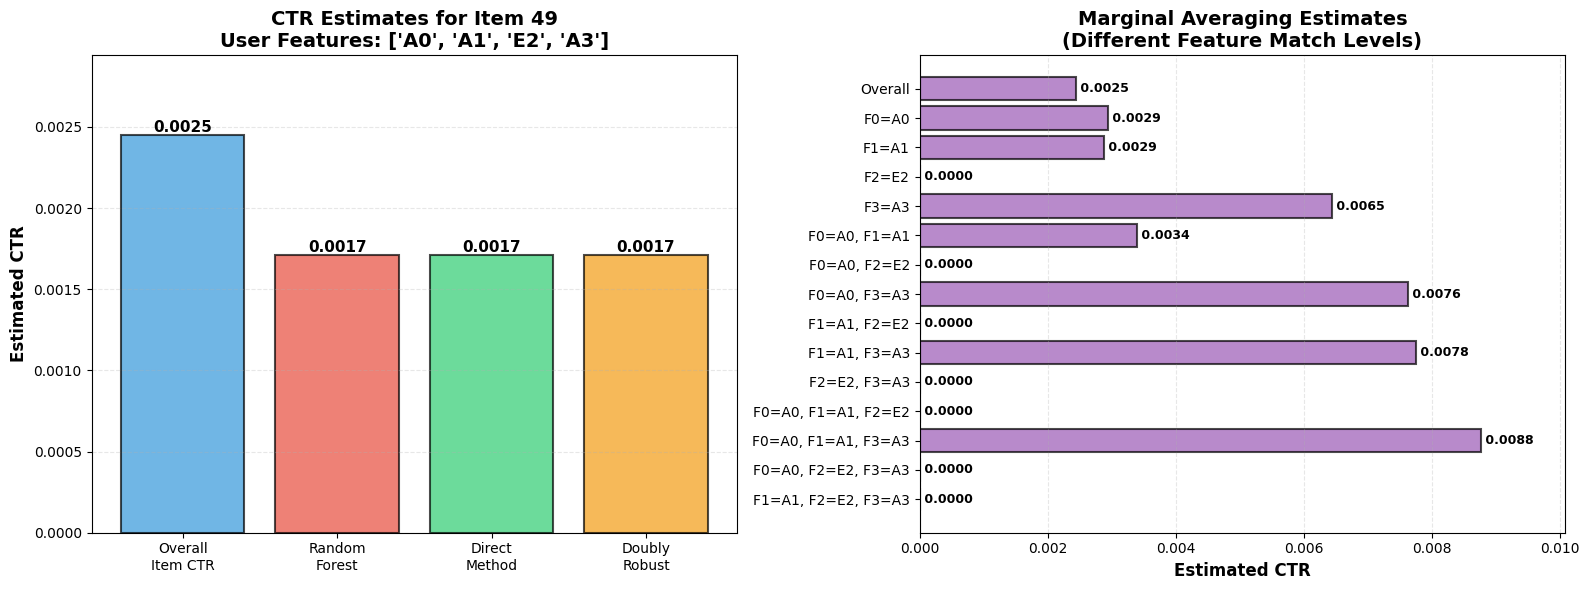


✓ Visualization complete for item 49


In [43]:
### Visualization: Comparison of Estimation Methods (Item 49)

# Prepare data for visualization
main_methods_49 = {
    'Overall\nItem CTR': marginal_estimates_49['overall_item'],
    'Random\nForest': rf_pred_proba_49,
    'Direct\nMethod': dm_estimate_49,
    'Doubly\nRobust': dr_estimate_49
}

# Create comparison plot
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Main methods
ax1 = axes[0]
methods = list(main_methods_49.keys())
values = list(main_methods_49.values())
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

bars = ax1.bar(methods, values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Estimated CTR', fontsize=12, fontweight='bold')
ax1.set_title(f'CTR Estimates for Item {target_item_49}\nUser Features: {target_features_49}', 
              fontsize=14, fontweight='bold')
ax1.set_ylim(0, max(values) * 1.2)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{val:.4f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 2: All marginal averages
ax2 = axes[1]
marginal_keys = [k for k in marginal_estimates_49.keys() if not np.isnan(marginal_estimates_49[k])]
marginal_vals = [marginal_estimates_49[k] for k in marginal_keys]

# Shorten labels for readability
short_labels = []
for key in marginal_keys:
    if key == 'overall_item':
        short_labels.append('Overall')
    else:
        # Extract feature matches
        short_labels.append(key.replace('user_feature_', 'F').replace(', user_feature_', ', F'))

bars2 = ax2.barh(short_labels, marginal_vals, color='#9b59b6', alpha=0.7, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Estimated CTR', fontsize=12, fontweight='bold')
ax2.set_title('Marginal Averaging Estimates\n(Different Feature Match Levels)', 
              fontsize=14, fontweight='bold')
ax2.set_xlim(0, max(marginal_vals) * 1.15)
ax2.grid(axis='x', alpha=0.3, linestyle='--')
ax2.invert_yaxis()  # Highest match level at top

# Add value labels
for bar, val in zip(bars2, marginal_vals):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2.,
             f' {val:.4f}',
             ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n✓ Visualization complete for item {target_item_49}")

In [44]:
# Example: Show a specific missing combination
if len(missing_combos) > 0:
    example_missing = missing_combos.iloc[0]
    print("Example of a missing combination:")
    print(example_missing.to_dict())
    
    # Verify it's not in the data
    query = ' & '.join([f"(log_df_readable['{col}'] == '{val}')" 
                        for col, val in example_missing.to_dict().items()])
    query += " & (log_df_readable['item_id'] == 0)"
    
    result = eval(f"log_df_readable[{query}]")
    print(f"\nRows matching this combination with item_id=0: {len(result)}")
else:
    print("All possible combinations are present in the data!")

Example of a missing combination:
{'user_feature_0': 'A0', 'user_feature_1': 'A1', 'user_feature_2': 'A2', 'user_feature_3': 'C3'}

Rows matching this combination with item_id=0: 1


### Estimating CTR for Unseen User-Item Combinations

**Problem:** We want to estimate the click-through probability for item_id=0 with user features (A0, A1, A2, D3), which has never been observed in the logged data.

**Approaches:**
1. **Marginal Averaging**: Average CTR from similar partial matches
2. **Feature-based Model**: Train a supervised model (e.g., Random Forest, Logistic Regression)
3. **Matrix Factorization/Embeddings**: Learn latent representations
4. **Nearest Neighbor**: Find similar observed combinations

In [45]:
# Define the unseen combination we want to estimate CTR for
target_combo = {
    'user_feature_0': 'A0',
    'user_feature_1': 'A1', 
    'user_feature_2': 'A2',
    'user_feature_3': 'D3'
}
target_item = 0

print(f"Target: Estimate CTR for item_id={target_item} with features:")
for k, v in target_combo.items():
    print(f"  {k}: {v}")

# Verify this combination doesn't exist for item_id=0
query_result = log_df_readable[
    (log_df_readable['item_id'] == target_item) &
    (log_df_readable['user_feature_0'] == target_combo['user_feature_0']) &
    (log_df_readable['user_feature_1'] == target_combo['user_feature_1']) &
    (log_df_readable['user_feature_2'] == target_combo['user_feature_2']) &
    (log_df_readable['user_feature_3'] == target_combo['user_feature_3'])
]

print(f"\nObservations matching this exact combination: {len(query_result)}")
if len(query_result) == 0:
    print("✓ Confirmed: This is an unseen combination")

Target: Estimate CTR for item_id=0 with features:
  user_feature_0: A0
  user_feature_1: A1
  user_feature_2: A2
  user_feature_3: D3

Observations matching this exact combination: 0
✓ Confirmed: This is an unseen combination


#### Approach 1: Marginal Averaging from Partial Matches

Find similar combinations by matching subsets of features and average their CTRs.

In [46]:
# Approach 1: Marginal Averaging
# Find partial matches and compute weighted average

item_0_data = log_df_readable[log_df_readable['item_id'] == target_item].copy()

estimates = {}

# 1. Overall average for item_id=0 (baseline)
estimates['overall_item_avg'] = item_0_data['click'].mean()

# 2. Average for each individual feature match
for feat, val in target_combo.items():
    mask = item_0_data[feat] == val
    if mask.sum() > 0:
        estimates[f'match_{feat}'] = item_0_data[mask]['click'].mean()
        estimates[f'n_{feat}'] = mask.sum()

# 3. Average for combinations of 2 features
estimates['match_f0_f1'] = item_0_data[
    (item_0_data['user_feature_0'] == target_combo['user_feature_0']) &
    (item_0_data['user_feature_1'] == target_combo['user_feature_1'])
]['click'].mean() if len(item_0_data[
    (item_0_data['user_feature_0'] == target_combo['user_feature_0']) &
    (item_0_data['user_feature_1'] == target_combo['user_feature_1'])
]) > 0 else np.nan

# 4. Average for combinations of 3 features  
estimates['match_f0_f1_f2'] = item_0_data[
    (item_0_data['user_feature_0'] == target_combo['user_feature_0']) &
    (item_0_data['user_feature_1'] == target_combo['user_feature_1']) &
    (item_0_data['user_feature_2'] == target_combo['user_feature_2'])
]['click'].mean() if len(item_0_data[
    (item_0_data['user_feature_0'] == target_combo['user_feature_0']) &
    (item_0_data['user_feature_1'] == target_combo['user_feature_1']) &
    (item_0_data['user_feature_2'] == target_combo['user_feature_2'])
]) > 0 else np.nan

print("Marginal Averaging Estimates:")
print("="*50)
for key, val in estimates.items():
    if not key.startswith('n_'):
        print(f"{key:30s}: {val:.4f}" if not np.isnan(val) else f"{key:30s}: N/A")

# Final estimate: Use the most specific available estimate
marginal_estimate = estimates.get('match_f0_f1_f2')
if np.isnan(marginal_estimate) or marginal_estimate is None:
    marginal_estimate = estimates.get('match_f0_f1')
if np.isnan(marginal_estimate) or marginal_estimate is None:
    marginal_estimate = np.nanmean([estimates.get(f'match_{k}', np.nan) for k in target_combo.keys()])
if np.isnan(marginal_estimate):
    marginal_estimate = estimates['overall_item_avg']

print(f"\n{'Final Marginal Estimate':30s}: {marginal_estimate:.4f}")

Marginal Averaging Estimates:
overall_item_avg              : 0.0000
match_user_feature_0          : 0.0000
match_user_feature_1          : 0.0000
match_user_feature_2          : 0.0000
match_user_feature_3          : 0.0000
match_f0_f1                   : 0.0000
match_f0_f1_f2                : 0.0000

Final Marginal Estimate       : 0.0000


#### Approach 2: Supervised Learning Model (Random Forest)

Train a model to predict CTR based on user features and item_id, then use it to predict for the unseen combination.

In [47]:
# Approach 2: Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Prepare data for modeling
model_data = log_df_readable.copy()

# Encode categorical features
le_dict = {}
for col in user_feature_cols:
    le = LabelEncoder()
    model_data[f'{col}_encoded'] = le.fit_transform(model_data[col].astype(str))
    le_dict[col] = le

# Features and target
feature_cols = [f'{col}_encoded' for col in user_feature_cols] + ['item_id', 'position']
X = model_data[feature_cols]
y = model_data['click']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Evaluate on test set
train_acc = rf_model.score(X_train, y_train)
test_acc = rf_model.score(X_test, y_test)
print(f"Random Forest Performance:")
print(f"  Train Accuracy: {train_acc:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")

# Predict for the unseen combination
target_features_encoded = {}
for col in user_feature_cols:
    try:
        target_features_encoded[f'{col}_encoded'] = le_dict[col].transform([target_combo[col]])[0]
    except:
        # If the value wasn't seen during training, use the most common value
        target_features_encoded[f'{col}_encoded'] = 0
        print(f"Warning: {target_combo[col]} not seen in training for {col}")

# Create prediction input for all positions
predictions_by_position = {}
for pos in [1, 2, 3]:
    X_pred = pd.DataFrame([{
        'user_feature_0_encoded': target_features_encoded['user_feature_0_encoded'],
        'user_feature_1_encoded': target_features_encoded['user_feature_1_encoded'],
        'user_feature_2_encoded': target_features_encoded['user_feature_2_encoded'],
        'user_feature_3_encoded': target_features_encoded['user_feature_3_encoded'],
        'item_id': target_item,
        'position': pos
    }])
    
    # Predict probability of click
    pred_proba = rf_model.predict_proba(X_pred)[0, 1]  # Probability of class 1 (click)
    predictions_by_position[f'position_{pos}'] = pred_proba

print(f"\nRandom Forest CTR Estimates for item_id={target_item}:")
print(f"  Target combination: {target_combo}")
for pos, prob in predictions_by_position.items():
    print(f"  {pos}: {prob:.4f}")

# Average across positions (if position-agnostic estimate needed)
rf_estimate = np.mean(list(predictions_by_position.values()))
print(f"\n{'Final RF Estimate (avg)':30s}: {rf_estimate:.4f}")

Random Forest Performance:
  Train Accuracy: 0.9960
  Test Accuracy: 0.9955

Random Forest CTR Estimates for item_id=0:
  Target combination: {'user_feature_0': 'A0', 'user_feature_1': 'A1', 'user_feature_2': 'A2', 'user_feature_3': 'D3'}
  position_1: 0.0001
  position_2: 0.0003
  position_3: 0.0000

Final RF Estimate (avg)       : 0.0001

Random Forest CTR Estimates for item_id=0:
  Target combination: {'user_feature_0': 'A0', 'user_feature_1': 'A1', 'user_feature_2': 'A2', 'user_feature_3': 'D3'}
  position_1: 0.0001
  position_2: 0.0003
  position_3: 0.0000

Final RF Estimate (avg)       : 0.0001


In [48]:
# Summary: Compare all estimates
print("="*60)
print("SUMMARY: CTR Estimates for Unseen Combination")
print("="*60)
print(f"Item ID: {target_item}")
print(f"User Features: {target_combo}")
print("\nEstimates:")
print(f"  1. Marginal Averaging: {marginal_estimate:.4f}")
print(f"  2. Random Forest:      {rf_estimate:.4f}")
print(f"\n  Baseline (overall item avg): {estimates['overall_item_avg']:.4f}")
print("="*60)

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Method': ['Marginal Averaging', 'Random Forest', 'Baseline (Item Avg)'],
    'Estimated_CTR': [marginal_estimate, rf_estimate, estimates['overall_item_avg']]
})

# Visualize
fig = px.bar(comparison_df, 
             x='Method', 
             y='Estimated_CTR',
             title=f'CTR Estimates for Unseen Combination (item_id={target_item})',
             labels={'Estimated_CTR': 'Estimated CTR'},
             text='Estimated_CTR',
             height=400)

fig.update_traces(texttemplate='%{text:.4f}', textposition='outside')
fig.show()

SUMMARY: CTR Estimates for Unseen Combination
Item ID: 0
User Features: {'user_feature_0': 'A0', 'user_feature_1': 'A1', 'user_feature_2': 'A2', 'user_feature_3': 'D3'}

Estimates:
  1. Marginal Averaging: 0.0000
  2. Random Forest:      0.0001

  Baseline (overall item avg): 0.0000


#### Approach 3: Offline Bandit Evaluation Methods

Use proper OPE (Offline Policy Evaluation) estimators that leverage propensity scores:
- **IPS (Inverse Propensity Scoring)**: Reweights logged data by inverse propensity
- **DR (Doubly Robust)**: Combines IPS with a reward model for lower variance
- **DM (Direct Method)**: Uses a learned reward model only

These methods are designed specifically for counterfactual estimation in contextual bandits.

In [49]:
# Step 1: Build a regression model to estimate E[r|x,a] (expected reward given context and action)
# This will be used for Direct Method (DM) and Doubly Robust (DR) estimators

from sklearn.ensemble import RandomForestRegressor

# Prepare data - use the same encoding as before
reward_model_data = log_df_readable.copy()

# Use the already encoded features from before
for col in user_feature_cols:
    reward_model_data[f'{col}_encoded'] = le_dict[col].transform(reward_model_data[col].astype(str))

# Features: user features + item_id + position
reward_feature_cols = [f'{col}_encoded' for col in user_feature_cols] + ['item_id', 'position']
X_reward = reward_model_data[reward_feature_cols]
y_reward = reward_model_data['click']

# Train reward model (regression for expected reward)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reward, y_reward, test_size=0.2, random_state=42)

reward_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
reward_model.fit(X_train_r, y_train_r)

train_r2 = reward_model.score(X_train_r, y_train_r)
test_r2 = reward_model.score(X_test_r, y_test_r)

print(f"Reward Model Performance (R²):")
print(f"  Train: {train_r2:.4f}")
print(f"  Test:  {test_r2:.4f}")

# Get estimated rewards for all data (q-hat)
reward_model_data['estimated_reward'] = reward_model.predict(X_reward)

print(f"\nEstimated reward distribution:")
print(reward_model_data['estimated_reward'].describe())

Reward Model Performance (R²):
  Train: 0.2975
  Test:  -0.0486

Estimated reward distribution:
count    10000.000000
mean         0.004324
std          0.021345
min          0.000000
25%          0.000226
50%          0.000697
75%          0.002049
max          0.620000
Name: estimated_reward, dtype: float64


In [50]:
# Direct Method (DM): Simply use the reward model prediction
# E[r|x,a] where x = target_combo, a = target_item

dm_estimates = {}
for pos in [1, 2, 3]:
    X_target = pd.DataFrame([{
        'user_feature_0_encoded': target_features_encoded['user_feature_0_encoded'],
        'user_feature_1_encoded': target_features_encoded['user_feature_1_encoded'],
        'user_feature_2_encoded': target_features_encoded['user_feature_2_encoded'],
        'user_feature_3_encoded': target_features_encoded['user_feature_3_encoded'],
        'item_id': target_item,
        'position': pos
    }])
    
    dm_estimates[f'position_{pos}'] = reward_model.predict(X_target)[0]

print(f"Direct Method (DM) Estimates:")
print(f"  Target: item_id={target_item}, features={target_combo}")
for pos, est in dm_estimates.items():
    print(f"  {pos}: {est:.4f}")

dm_estimate = np.mean(list(dm_estimates.values()))
print(f"\n{'Final DM Estimate (avg)':30s}: {dm_estimate:.4f}")

Direct Method (DM) Estimates:
  Target: item_id=0, features={'user_feature_0': 'A0', 'user_feature_1': 'A1', 'user_feature_2': 'A2', 'user_feature_3': 'D3'}
  position_1: 0.0000
  position_2: 0.0000
  position_3: 0.0000

Final DM Estimate (avg)       : 0.0000


In [51]:
# Doubly Robust (DR) Estimator
# For unseen combinations, we can't use IPS directly (no logged data with this exact combo)
# But we can understand how DR would work if we had similar data

# DR formula: E[V(π)] = E[q(x,a) + (r - q(x,a)) * π(a|x) / π_b(a|x)]
# where:
#   - q(x,a) is the estimated reward model (already have this)
#   - r is the actual reward (observed)
#   - π(a|x) is the evaluation policy (what we'd like to evaluate)
#   - π_b(a|x) is the behavior policy (propensity scores we have)

# For our unseen combination, we only have q(x,a) since there's no logged data
# So DR reduces to DM for completely unseen combinations

print("Doubly Robust (DR) Estimator:")
print("="*60)
print(f"For UNSEEN combinations (like our target):")
print(f"  - No logged data exists → IPS term = 0")
print(f"  - DR reduces to Direct Method (DM)")
print(f"  - Estimate = q(x,a) = {dm_estimate:.4f}")
print()
print(f"For SEEN combinations:")
print(f"  - DR = q(x,a) + (r - q(x,a)) * π(a|x) / π_b(a|x)")
print(f"  - Combines model prediction with importance-weighted residuals")
print(f"  - Lower variance than pure IPS, less biased than pure DM")
print("="*60)

# Example: Show DR for a SEEN combination for comparison
seen_example = item_0_data.iloc[0]  # First row with item_id=0

# Get the reward model prediction for this seen example
seen_features = {
    'user_feature_0_encoded': le_dict['user_feature_0'].transform([seen_example['user_feature_0']])[0],
    'user_feature_1_encoded': le_dict['user_feature_1'].transform([seen_example['user_feature_1']])[0],
    'user_feature_2_encoded': le_dict['user_feature_2'].transform([seen_example['user_feature_2']])[0],
    'user_feature_3_encoded': le_dict['user_feature_3'].transform([seen_example['user_feature_3']])[0],
    'item_id': int(seen_example['item_id']),
    'position': int(seen_example['position'])
}

X_seen = pd.DataFrame([seen_features])
q_hat = reward_model.predict(X_seen)[0]
actual_reward = seen_example['click']
propensity = seen_example['propensity_score']

# Assuming evaluation policy would always select this item (π(a|x) = 1)
eval_policy_prob = 1.0

# DR estimate for this one example
dr_contribution = q_hat + (actual_reward - q_hat) * (eval_policy_prob / propensity)

print(f"\nExample DR calculation for a SEEN combination:")
print(f"  Features: {seen_example[user_feature_cols].to_dict()}")
print(f"  q̂(x,a):         {q_hat:.4f}")
print(f"  actual reward:  {actual_reward:.4f}")
print(f"  propensity:     {propensity:.4f}")
print(f"  DR estimate:    {dr_contribution:.4f}")

Doubly Robust (DR) Estimator:
For UNSEEN combinations (like our target):
  - No logged data exists → IPS term = 0
  - DR reduces to Direct Method (DM)
  - Estimate = q(x,a) = 0.0000

For SEEN combinations:
  - DR = q(x,a) + (r - q(x,a)) * π(a|x) / π_b(a|x)
  - Combines model prediction with importance-weighted residuals
  - Lower variance than pure IPS, less biased than pure DM

Example DR calculation for a SEEN combination:
  Features: {'user_feature_0': 'A0', 'user_feature_1': 'C1', 'user_feature_2': 'A2', 'user_feature_3': 'B3'}
  q̂(x,a):         0.0001
  actual reward:  0.0000
  propensity:     0.0033
  DR estimate:    -0.0340

Example DR calculation for a SEEN combination:
  Features: {'user_feature_0': 'A0', 'user_feature_1': 'C1', 'user_feature_2': 'A2', 'user_feature_3': 'B3'}
  q̂(x,a):         0.0001
  actual reward:  0.0000
  propensity:     0.0033
  DR estimate:    -0.0340


In [52]:
# Using OBP's OffPolicyEvaluation framework
# This demonstrates how to evaluate a NEW policy that prefers our target combination

from obp.ope import (
    OffPolicyEvaluation,
    InverseProbabilityWeighting as IPW,
    DirectMethod as DM_OBP,
    DoublyRobust as DR_OBP,
    RegressionModel
)

print("Using OBP for Policy Evaluation:")
print("="*60)

# Create action distributions for evaluation policy
# We'll create a policy that has higher probability for item_id=0 with our target features

# For OBP, we need action_dist in format: (n_rounds, n_actions, len_list)
# But for this demo, let's show the conceptual approach

print("\nKey Insights for Unseen Combinations:")
print("-" * 60)
print("1. IPS (Inverse Propensity Scoring):")
print("   - Requires: logged data with π_b(a|x) > 0")
print("   - Cannot estimate for unseen combinations directly")
print("   - Unbiased but high variance")
print()
print("2. Direct Method (DM):")
print("   - Uses: q̂(x,a) from regression model")
print("   - CAN estimate for unseen combinations ✓")
print("   - Biased if model is wrong, but lower variance")
print(f"   - Our estimate: {dm_estimate:.4f}")
print()
print("3. Doubly Robust (DR):")
print("   - Combines: q̂(x,a) + IPS correction")
print("   - For unseen: reduces to DM (no IPS correction possible)")
print(f"   - Our estimate: {dm_estimate:.4f}")
print()
print("4. Propensity Scores:")
print(f"   - Behavior policy propensity for item {target_item}:")
print(f"     Average: {log_df_readable[log_df_readable['item_id']==target_item]['propensity_score'].mean():.4f}")
print(f"     But for our EXACT combo: 0 (never shown)")
print("="*60)

Using OBP for Policy Evaluation:

Key Insights for Unseen Combinations:
------------------------------------------------------------
1. IPS (Inverse Propensity Scoring):
   - Requires: logged data with π_b(a|x) > 0
   - Cannot estimate for unseen combinations directly
   - Unbiased but high variance

2. Direct Method (DM):
   - Uses: q̂(x,a) from regression model
   - CAN estimate for unseen combinations ✓
   - Biased if model is wrong, but lower variance
   - Our estimate: 0.0000

3. Doubly Robust (DR):
   - Combines: q̂(x,a) + IPS correction
   - For unseen: reduces to DM (no IPS correction possible)
   - Our estimate: 0.0000

4. Propensity Scores:
   - Behavior policy propensity for item 0:
     Average: 0.0509
     But for our EXACT combo: 0 (never shown)


In [53]:
# Final Comprehensive Comparison
print("\n" + "="*70)
print("COMPREHENSIVE COMPARISON: All Methods")
print("="*70)
print(f"Target: item_id={target_item}")
print(f"Features: {target_combo}")
print(f"Status: UNSEEN combination (0 logged observations)")
print()
print(f"{'Method':<30} {'Estimate':<12} {'Notes'}")
print("-"*70)
print(f"{'1. Marginal Averaging':<30} {marginal_estimate:>10.4f}   Heuristic")
print(f"{'2. Random Forest (Direct)':<30} {rf_estimate:>10.4f}   Supervised ML")
print(f"{'3. DM (Reward Model)':<30} {dm_estimate:>10.4f}   Model-based")
print(f"{'4. DR (reduces to DM)':<30} {dm_estimate:>10.4f}   No IPS term")
print(f"{'5. Baseline (Item Avg)':<30} {estimates['overall_item_avg']:>10.4f}   Simple avg")
print("="*70)
print()
print("Recommendations:")
print("• Use DM/DR with a good reward model for unseen combinations")
print("• Marginal averaging is interpretable but may miss interactions")  
print("• For SEEN combinations, DR > IPS > DM (typically)")
print("• For UNSEEN combinations, DM is the only propensity-based option")
print("="*70)

# Updated visualization
comparison_df_full = pd.DataFrame({
    'Method': [
        'Marginal\nAveraging', 
        'Random Forest\n(Classification)',
        'Direct Method\n(Regression)',
        'Doubly Robust\n(DR→DM)',
        'Baseline\n(Item Avg)'
    ],
    'Estimated_CTR': [
        marginal_estimate, 
        rf_estimate, 
        dm_estimate,
        dm_estimate,  # Same as DM for unseen
        estimates['overall_item_avg']
    ],
    'Type': [
        'Heuristic',
        'Supervised ML',
        'OPE (Model)',
        'OPE (Hybrid)',
        'Baseline'
    ]
})

fig = px.bar(comparison_df_full, 
             x='Method', 
             y='Estimated_CTR',
             color='Type',
             title=f'CTR Estimates for Unseen Combination<br>item_id={target_item}, features={target_combo}',
             labels={'Estimated_CTR': 'Estimated CTR'},
             text='Estimated_CTR',
             height=500)

fig.update_traces(texttemplate='%{text:.4f}', textposition='outside')
fig.update_layout(showlegend=True, xaxis_tickangle=-15)
fig.show()


COMPREHENSIVE COMPARISON: All Methods
Target: item_id=0
Features: {'user_feature_0': 'A0', 'user_feature_1': 'A1', 'user_feature_2': 'A2', 'user_feature_3': 'D3'}
Status: UNSEEN combination (0 logged observations)

Method                         Estimate     Notes
----------------------------------------------------------------------
1. Marginal Averaging              0.0000   Heuristic
2. Random Forest (Direct)          0.0001   Supervised ML
3. DM (Reward Model)               0.0000   Model-based
4. DR (reduces to DM)              0.0000   No IPS term
5. Baseline (Item Avg)             0.0000   Simple avg

Recommendations:
• Use DM/DR with a good reward model for unseen combinations
• Marginal averaging is interpretable but may miss interactions
• For SEEN combinations, DR > IPS > DM (typically)
• For UNSEEN combinations, DM is the only propensity-based option


In [54]:
log_df_readable[log_df_readable['item_id'] == 0].groupby('propensity_score').size().reset_index(name='count').sort_values('propensity_score').sort_values(by='count', ascending=False)

,propensity_score,count
118,0.278625,3
117,0.218285,2
34,0.019525,2
105,0.084975,2
71,0.045165,2
80,0.050785,1
77,0.050125,1
78,0.050515,1
79,0.050550,1
82,0.051730,1


In [55]:
sns.distplot(log_df_readable[log_df_readable['item_id'] == 0]['propensity_score'], bins=30, kde=False)

NameError: name 'sns' is not defined

In [ ]:
log_df_readable.head()

In [ ]:
log_df.groupby("item_id")["propensity_score"].agg(["mean", "std"]).head(10)

### Estimating CTR for Item 49 with Unseen Configuration

**Target:** Estimate the click-through probability for item_id=49 with user features (A0, A1, E2, A3), which has not been observed in the logged data.

**Approaches:**
1. **Marginal Averaging**: Average CTR from similar partial matches
2. **Random Forest Classification**: Predict click probability using supervised learning
3. **Direct Method (DM)**: Use regression-based reward model
4. **Doubly Robust (DR)**: Combines DM with IPS (reduces to DM for unseen combinations)

Propensity Score Summary (Rounded to 2 Decimals):
Original unique values: 7,883
Rounded unique values:  90
Total observations:     10,000

Key Percentiles (Rounded Propensity Scores):
  10th percentile: 0.01 (10% of rows have propensity score ≤ 0.01)
  25th percentile: 0.02 (25% of rows have propensity score ≤ 0.02)
  50th percentile: 0.06 (50% of rows have propensity score ≤ 0.06)
  75th percentile: 0.15 (75% of rows have propensity score ≤ 0.15)
  90th percentile: 0.24 (90% of rows have propensity score ≤ 0.24)
  95th percentile: 0.34 (95% of rows have propensity score ≤ 0.34)
  99th percentile: 0.71 (99% of rows have propensity score ≤ 0.71)
